# 前言

**基金重仓超配个股的特征：**本文分析的基金池为，聚宽场外基金数据中的开放式基金--股票型及混合型基金；将基金池中所有基金季报披露的十大重仓股取并集，即为本文研究的基金重仓股。

由于聚宽数据基金数据分级不够精细,如果有条件需要剔除股票型基金中的被动指数型、指数增强型；混合型中的偏债混合型、平衡混合型。

本文使用了两种构建方式构建因子：

1. 基金重仓因子：将全市场中的基金持仓个股的持股市值除以总体的市值的比列作为因子。(详细构建方式见下文)
2. 基金重仓超配因子:使用上一步的因子与指数持仓轧差，以体现超配的概念。（详细构建见下午,海通证券的构建中大于0的部分用1表示，小于0的部分使用0标记）

我们分别构建了滚动一年期累计收益率头部基金组合(基于基金动量考虑)、滚动一年期头部夏普基金组合对因子进行测试分析，发现重仓因子、超配因子均受基金池的影响；与此同时我们分别在基金重仓超配因子中使用了全市场、沪深300、中证500、创业板对其进行测试，发现在中证500中效果较好。

In [1]:
# 初始库的引入
import sys
sys.path.append('../..')

from BuildPeriodDate import tdaysoffset

import numpy as np
import pandas as pd
import empyrical as ep
import statsmodels.api as sm
from scipy import stats

import alphalens as al
from alphalens import plotting
import alphalens.performance as perf

from jqdata import *
from sqlalchemy.sql import func
from jqfactor import (Factor, calc_factors)

from functools import reduce
from tqdm import tqdm_notebook
from typing import (Tuple, List)
from dateutil.parser import parse

import seaborn as sns
import matplotlib.pyplot as plt


mpl.rcParams['font.family'] = 'serif'  # pd.plot中文
# 用来正常显示负号
mpl.rcParams['axes.unicode_minus'] = False
# 图表主题
plt.style.use('seaborn')

In [2]:
# 查询基金代码
def query_fund_codes(underlying_asset_type:list,watch_date:str)->list:
    
    '''
    查询基金开发式基金中：各板块基金代码
    --------
        underlying_asset_type：股票型、混合型等
        watch_date：查询日
    上市日期小于watch_date
    '''
    
    if isinstance(underlying_asset_type,str):
        underlying_asset_type = [underlying_asset_type]
    q = query(finance.FUND_MAIN_INFO.main_code).filter(
          finance.FUND_MAIN_INFO.operate_mode=='开放式基金',
          finance.FUND_MAIN_INFO.underlying_asset_type.in_(underlying_asset_type),
          finance.FUND_MAIN_INFO.start_date < watch_date)

    fund_main_codes = finance.run_query(q)['main_code'].values.tolist()
    
    return fund_main_codes

# 获取净值
def get_fund_nav(codes:list,start:str,end:str,fields:list)->pd.DataFrame:
    
    '''获取基金净值'''
    
    if not fields:
        raise ValueError('fields不能为空')
    
    if isinstance(fields,str):
        fields = [fields]
        
    if isinstance(codes,str):
        codes = [codes]
    
    LIMIT = 5000
    q = query(func.count('*')).filter(
        finance.FUND_NET_VALUE.code.in_(codes),
        finance.FUND_NET_VALUE.day>=start,
        finance.FUND_NET_VALUE.day<=end)
    
    sum_count = finance.run_query(q).iloc[0,0]
    
    q_str = ','.join([f'finance.FUND_NET_VALUE.{i}' for i in ['day','code'] + fields])
    # finance.FUND_NET_VALUE
    q_f = query(q_str).filter(
                  finance.FUND_NET_VALUE.code.in_(codes),
                  finance.FUND_NET_VALUE.day>=start,
                  finance.FUND_NET_VALUE.day<=end)
    
    df_list = []
    if sum_count > LIMIT:
        
        for i in range(0,sum_count,LIMIT):
            df_list.append(finance.run_query(q_f.offset(i)))
        df = pd.concat(df_list)
    else:
        
        df = finance.run_query(q_f)
        
    return df

# 未来数据的对应方法在后续的处理中
def query_quarterly_holdstocks(code:list,rptDate:str)->pd.DataFrame:
    '''
    查询季报报持仓
    -----------
        code:list
        rptDate:报告期
    -----------
        return 
            -----------------------------------------------------------------
            |  | code | pub_date |period_end|report_type|symbol| market_cap |
            -----------------------------------------------------------------
            | 1|000042|2021-01-21|2020-12-31|  第四季度 |601633|7.913633e+06|
            ----------------------------------------------------------------
    '''
    import math
    
    LIMIT = 3000 # 查询限制
    
    # 总计条数
    q_t = query(func.count('*')).filter( finance.FUND_PORTFOLIO_STOCK.code.in_(code),
            ~finance.FUND_PORTFOLIO_STOCK.report_type.in_(["半年度", '年度']),
            finance.FUND_PORTFOLIO_STOCK.period_end == rptDate)
    
    
    total_num = finance.run_query(q_t).iat[0,0]
    
    iter_num = math.ceil(total_num / LIMIT)
    
    df_list = []
    # 注意有反向字符
    q = query(finance.FUND_PORTFOLIO_STOCK.code,
              finance.FUND_PORTFOLIO_STOCK.pub_date,
              finance.FUND_PORTFOLIO_STOCK.period_end,
              finance.FUND_PORTFOLIO_STOCK.report_type,
              finance.FUND_PORTFOLIO_STOCK.symbol,
              finance.FUND_PORTFOLIO_STOCK.market_cap).filter(
        finance.FUND_PORTFOLIO_STOCK.code.in_(code),
        ~finance.FUND_PORTFOLIO_STOCK.report_type.in_(["半年度", '年度']),
        finance.FUND_PORTFOLIO_STOCK.period_end == rptDate)
    
    for i in range(0,iter_num,LIMIT):
        df_list.append(finance.run_query(q.offset(i)))
    
    hold_df = pd.concat(df_list)
    return hold_df

In [3]:
'''
主要风险指标计算
'''
# 风险指标
def Strategy_performance(return_df: pd.DataFrame, periods='daily') -> pd.DataFrame:
    '''计算风险指标 默认为日度:日度调仓'''
    
    if isinstance(return_df,pd.Series):
        
        return_df = return_df.to_frame('ret')
        
    ser: pd.DataFrame = pd.DataFrame()
        
    ser['年化收益率'] = ep.annual_return(return_df, period=periods)
    ser['波动率'] = return_df.apply(lambda x: ep.annual_volatility(x,period=periods))
    ser['夏普'] = return_df.apply(ep.sharpe_ratio,risk_free=0.03/252, period=periods)
    ser['最大回撤'] = return_df.apply(lambda x: ep.max_drawdown(x))
    ser['Calmar'] = return_df.apply(lambda x:ep.calmar_ratio(x,period=periods))
    if 'benchmark' in return_df.columns:

        select_col = [col for col in return_df.columns if col != 'benchmark']

        ser['IR'] = return_df[select_col].apply(
            lambda x: information_ratio(x, return_df['benchmark']))
        ser['Alpha'] = return_df[select_col].apply(
            lambda x: ep.alpha(x, return_df['benchmark'], period=periods))

    return ser.T

def information_ratio(returns, factor_returns):
    """
    Determines the Information ratio of a strategy.

    Parameters
    ----------
    returns : :py:class:`pandas.Series` or pd.DataFrame
        Daily returns of the strategy, noncumulative.
        See full explanation in :func:`~empyrical.stats.cum_returns`.
    factor_returns: :class:`float` / :py:class:`pandas.Series`
        Benchmark return to compare returns against.

    Returns
    -------
    :class:`float`
        The information ratio.

    Note
    -----
    See https://en.wikipedia.org/wiki/information_ratio for more details.

    """
    if len(returns) < 2:
        return np.nan

    active_return = _adjust_returns(returns, factor_returns)
    tracking_error = np.std(active_return, ddof=1)
    if np.isnan(tracking_error):
        return 0.0
    if tracking_error == 0:
        return np.nan
    return np.mean(active_return) / tracking_error

def _adjust_returns(returns, adjustment_factor):
    """
    Returns a new :py:class:`pandas.Series` adjusted by adjustment_factor.
    Optimizes for the case of adjustment_factor being 0.

    Parameters
    ----------
    returns : :py:class:`pandas.Series`
    adjustment_factor : :py:class:`pandas.Series` / :class:`float`

    Returns
    -------
    :py:class:`pandas.Series`
    """
    if isinstance(adjustment_factor, (float, int)) and adjustment_factor == 0:
        return returns.copy()
    return returns - adjustment_factor

In [4]:
# 获取A股FF3因子
def get_ff3_csv():
    
    '''获取FF3月度因子
    
    数据来源：https://www.factorwar.com/data/factor-models/
    '''
    
    import requests
    import io

    url = 'http://www.factorwar.com/wp-content/uploads/2021/04/Fama-French三因子模型（经典算法）月收益率（截至到20210331）.csv'
    s = requests.get(url).content
    c = pd.read_csv(io.StringIO(s.decode('utf-8')))
    
    return c.set_index('date')

# 1. 因子构建

## 1.1 基金重仓因子

**基金重仓因子定义**为以基金池中所有基金的重仓股为股票池，统计该股票池中基金对于每只个股的持仓市值占比（下简称重仓池权重）

从认知上来说该因子应该是基金持仓的比列越大越好。

In [7]:
# 获取基金持股信息

from typing import Callable

def query_fundhandle_data(startDt: str, endDt: str,func:Callable=None) -> pd.Series:
    '''获取基金持股信息'''
    df_list = []
    periods = pd.date_range(start, end, freq='Q')
    for quarter in tqdm_notebook(periods, desc='数据获取'):

        # 获取基金代码
        codes = query_fund_codes(['股票型', '混合型'], quarter)
        if func:
            codes = func(codes,quarter)
        # 获取持仓信息
        tmp = query_quarterly_holdstocks(codes, quarter)
        df_list.append(tmp)

    df = pd.concat(df_list)

    return _preprocessing_data(df)


def _filter_sharpe_fund(codes:list,watch_date:str)->list:
    '''取过去一年夏普头部10%d的基金'''
    begin = get_trade_days(end_date=watch_date,count=251)[0]
    nav_df = get_fund_nav(codes,begin,watch_date,'refactor_net_value')
    nav_df = pd.pivot_table(nav_df,index='day',columns='code',values='refactor_net_value')
    
    sharpe = nav_df.apply(ep.sharpe_ratio) # 计算过去一年的夏普
    rank = pd.qcut(sharpe,10,labels=list(range(1,11)))
    
    return rank[rank==10].index.tolist()
    
def _filter_annual_fund(codes:list,watch_date:str)->list:
    '''过去一年的收益率前50%'''
    begin = get_trade_days(end_date=watch_date,count=251)[0]
    nav_df = get_fund_nav(codes,begin,watch_date,'refactor_net_value')
    nav_df = pd.pivot_table(nav_df,index='day',columns='code',values='refactor_net_value')
    
    annual_return = nav_df.apply(ep.annual_return) # 计算过去一年的年化收益
    median = annual_return.median()
    
    return annual_return[annual_return > median].index.tolist()

    
# 数据预处理 含防止未来数据的处理


def _preprocessing_data(handle_data: pd.DataFrame) -> pd.Series:
    '''数据预处理
    --------
        handle_data数据结构如下
            -----------------------------------------------------------------    
            |  | code | pub_date |period_end|report_type|symbol|  market_cap |
            -----------------------------------------------------------------
            |0 |000001|2014-01-20|2013-12-31|  第四季度 | 600887|3.783095e+08|
            -----------------------------------------------------------------
            |1 |000001|2014-01-20|2013-12-31|  第四季度 | 601633|2.264350e+08|
            -----------------------------------------------------------------
    -----------
        return 
    '''

    df = handle_data.copy()

    # 使用每期报告的最后一个披露日为换仓日 尽可能避免未来数据 但实际中最后在滞后一期
    # 因为数据更新可能并没那么及时
    df['pub_date'] = df.groupby('period_end')[
        'pub_date'].transform(lambda x: x.max())
    df['pub_date'] = pd.to_datetime(df['pub_date'])

    # 代码转为jqcode
    security_dic = transform2jqcode(df['symbol'].unique())
    df['symbol'] = df['symbol'].map(security_dic)

    # 过滤港股
    df = df[df['symbol'].str[-2:] != 'HK']
    
    ## 因子的计算
    # 计算每期股票的持仓市值占比
    # 以全市场基金持仓为股票池 汇总基金持股市值中占总的基金持股市场的比列情况
    group_df = df.groupby(['pub_date', 'symbol'])['market_cap'].sum(
    ) / df.groupby(['pub_date'])['market_cap'].sum()

    # 以下代码：在处理好数据后 将数据重采样至每个月末
    group_df = group_df.unstack()
    begin = group_df.index.min()
    end = group_df.index.max()

    idx = pd.to_datetime(GetTradePeriod(begin, end))
    all_idx = pd.to_datetime(idx.tolist() + group_df.index.tolist()).unique()

    group_df = group_df.reindex(all_idx).sort_index().fillna(method='pad')
    group_df = group_df.loc[idx].copy()
    group_df = group_df.unstack().swaplevel().sort_index()
    group_df.index.names = ['date', 'symbol']

    return group_df.dropna()

# 将交易代码转为jq_code


def transform2jqcode(codes: list) -> dict:
    '''
    将交易代码转为jq_code,
    '''
    code_dic = {}
    for code in codes:

        try:
            jq_code = normalize_code(code)
        except:

            jq_code = code + '.HK'

        code_dic[code] = jq_code

    return code_dic

# 获取年末季末时点


def GetTradePeriod(start_date: str, end_date: str, freq: str = 'ME') -> list:
    '''
    start_date/end_date:str YYYY-MM-DD
    freq:M月，Q季,Y年 默认ME E代表期末 S代表期初
    ================
    return  list[datetime.date]
    '''
    days = pd.Index(pd.to_datetime(get_trade_days(start_date, end_date)))
    idx_df = days.to_frame()

    if freq[-1] == 'E':
        day_range = idx_df.resample(freq[0]).last()
    else:
        day_range = idx_df.resample(freq[0]).first()

    day_range = day_range[0].dt.date

    return day_range.dropna().values.tolist()



# 因子收益率
def get_factor_returns(factor:pd.DataFrame,rename:dict=None)->pd.DataFrame:
    '''计算因子收益'''
    df = pd.pivot_table(factor.reset_index(
        ), index='date', columns='factor_quantile', values=1)
    
    if rename is not None:
        df.rename(columns=rename,inplace=True)
        
    return df

# 画图
def plot_factor_returns(factor_ret:pd.DataFrame,benchmark:pd.Series,title:str='',ax=None):
    
    if ax is None:
        ax = plt.gca()
        
    mpl.rcParams['font.family'] = 'serif'

    ax.set_title(title)
    factor_ret.plot(ax=ax)
    (benchmark / benchmark[0]
     ).plot(ax=ax, color='darkgray', ls='--', label='benchmark')
    ax.legend(loc='upper left')
    
    return ax

In [7]:
start = '2013-12-31'
end = '2020-12-31'

# 获取基金持仓数据
handle_data = query_fundhandle_data(start,end)

In [8]:
# 匹配因子收盘数据
def get_stock_price(handle_data: pd.DataFrame, last_period: str) -> pd.DataFrame:

    price_list = []

    for trade, df in tqdm_notebook(handle_data.groupby(level='date'), desc='数据下载'):
        
        codes = df.index.get_level_values(1)
        codes = [i for i in codes if get_security_info(i) is not None]
        close = get_price(codes, end_date=trade, count=1, fields='close', panel=False)

        price_list.append(close)
    
    codes = df.index.get_level_values(1)
    codes = [i for i in codes if get_security_info(i) is not None]
    close = get_price(codes, end_date=last_period, count=1, fields='close', panel=False)

    price_list.append(close)

    pricing = pd.concat(price_list)
    pricing = pd.pivot_table(pricing, index='time',
                             columns='code', values='close')

    return pricing

In [9]:
last_period = '2021-02-22'
pricing = get_stock_price(handle_data,last_period)

In [10]:
# periods 表示间隔为1 也就是季度换仓 group_df的时间是季度
factor_data1 = al.utils.get_clean_factor_and_forward_returns(handle_data,
                                                            pricing,
                                                            quantiles=10,
                                                            periods=(1,))

Dropped 0.0% entries from factor data (0.0% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


In [11]:
# 分组收益
returns1 = get_factor_returns(factor_data1,{1:'低',10:'高'})

# 获取基准
benchmark = get_price('000300.XSHG', start, end, fields='close', panel=True)
benchmark = benchmark.reindex(pricing.index)

## 1.2 基金重仓超配因子

**基金重仓因子定义为**以基金池中所有基金的重仓股为股票池，统计该股票池中基金对于每只个股的持仓市值占比（下简称重仓池权重），并与全市场所有个股的市值权重（下简称市场权重）进行对比。若个股的重仓池权重高于比较基准中 （如全 A个股市值分布/沪深 300 指数等）该个股的权重(基金池中该个股权重-市场中该个股权重)，为基金重仓因子。

这里涉及基金持仓与市场持仓的一个对比，所以有一个超配的概念。不过这里的市场可以是全A也可以是某一基准指数,基准的选择对该因子也会有较大的影响。

In [9]:
# 改进基金重仓因子
def get_fundmkt_diff(handle_data: pd.Series,pool:str='A') -> pd.Series:
    '''
    基金持股占比与市场持股占比的差为因子值
    '''

    mkt_dic = {}

    for trade, ser in handle_data.groupby(level=0):

        codes = ser.index.get_level_values(1).tolist()
        
        mkt_ser = get_all_stock_mkt(trade,pool)
        mkt_ser = mkt_ser.reindex(codes) / mkt_ser.sum()
        dif = ser.loc[trade] - mkt_ser

        mkt_dic[trade] = dif.dropna() # 丢弃缺失值

    df = pd.concat(mkt_dic)
    df.index.names = ['date', 'symbol']

    return df


def get_all_stock_mkt(watch_date: str,stock_pool:str='A') -> pd.Series:
    
    '''全市场
    -------
        return index-code value-mkt_cap
    '''
    
    if stock_pool == 'A':
    
        stocks = get_index_stocks(
            '399001.XSHE', watch_date) + get_index_stocks('000001.XSHG', watch_date)

    else:

        stocks = get_index_stocks(stock_pool, watch_date)

    df = get_valuation(stocks, end_date=watch_date,
                    fields='circulating_market_cap', count=1)
                    
    return df.set_index('code')['circulating_market_cap']


In [13]:
# 数据获取
dif_data = get_fundmkt_diff(handle_data)

## 1.3 基金重仓因子与基金重仓超配因子对比

我们定义的全市场上是000001.SH加399001.SZ的成分股,部分基金持仓中的股票可能不在这个股票池中,所以导致基金重仓超配因子标的数量少于基金重仓因子数量。

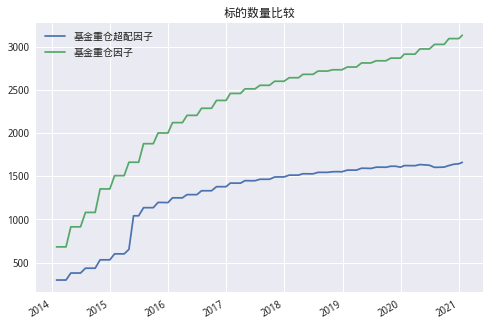

In [14]:
mpl.rcParams['font.family'] = 'serif'
dif_data.reset_index()['date'].value_counts().plot(label='基金重仓超配因子',title='标的数量比较')
handle_data.reset_index()['date'].value_counts().plot(label='基金重仓因子')
plt.legend()

In [15]:
# periods 表示间隔为1 也就是季度换仓 group_df的时间是季度
factor_data2 = al.utils.get_clean_factor_and_forward_returns(dif_data,
                                                            pricing,
                                                            quantiles=10,
                                                            periods=(1,))

Dropped 0.0% entries from factor data (0.0% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


In [16]:
# 分组收益
returns2 = get_factor_returns(factor_data2,{1:'低',10:'高'})

# 获取基准
benchmark = get_price('000300.XSHG', start, end, fields='close', panel=True)
benchmark = benchmark.reindex(pricing.index)

从分组净值走势来看改进后的基金重仓因的收益要比原始因子有一定的提升。组间间隔更具明显。但基本走势一致。

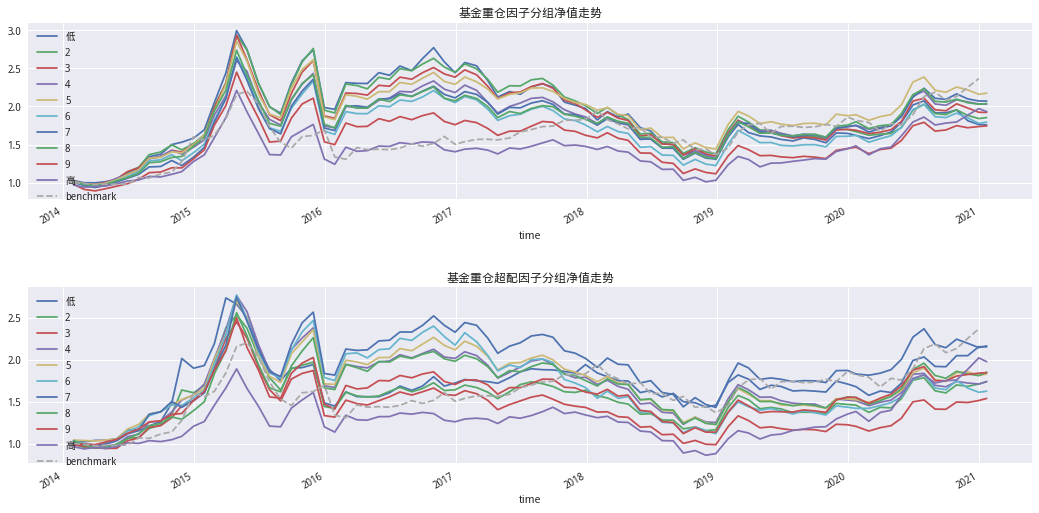

In [17]:
# 计算净值
nav_df1 = ep.cum_returns(returns1).add(1)
nav_df2 = ep.cum_returns(returns2).add(1)

fig, axes = plt.subplots(2, figsize=(18, 9))
mpl.rcParams['font.family'] = 'serif'
plot_factor_returns(nav_df1,benchmark['close'],'基金重仓因子分组净值走势',axes[0])
plot_factor_returns(nav_df2,benchmark['close'],'基金重仓超配因子分组净值走势',axes[1])

plt.subplots_adjust(hspace=0.5)

从下面的回测指标中可以看到,基金重仓超配因子各组数据相较于基金重仓因子有所提升。

In [41]:
(Strategy_performance(returns1,'monthly').style.format('{:.2%}')
                                         .set_caption('基金重仓因子'))

factor_quantile,低,2,3,4,5,6,7,8,9,高
年化收益率,8.29%,9.11%,9.66%,10.52%,11.59%,8.60%,10.83%,10.57%,8.18%,9.75%
波动率,29.24%,29.54%,29.19%,27.20%,28.05%,28.83%,28.90%,27.88%,27.75%,26.02%
夏普,41.14%,43.51%,45.42%,49.83%,52.52%,42.34%,49.27%,49.29%,41.58%,48.34%
最大回撤,-56.46%,-53.07%,-54.01%,-49.18%,-49.57%,-53.82%,-50.50%,-51.94%,-54.44%,-54.29%
Calmar,14.68%,17.16%,17.89%,21.39%,23.38%,15.97%,21.44%,20.35%,15.02%,17.96%


In [42]:
(Strategy_performance(returns2,'monthly').style.format('{:.2%}')
                                         .set_caption('基金重仓超配因子'))

factor_quantile,低,2,3,4,5,6,7,8,9,高
年化收益率,11.42%,8.10%,6.26%,8.12%,8.89%,7.08%,11.51%,9.07%,9.02%,10.08%
波动率,26.96%,26.21%,26.22%,27.21%,26.74%,28.41%,28.70%,27.68%,26.62%,25.84%
夏普,52.41%,42.14%,35.80%,41.83%,44.70%,37.68%,51.68%,44.54%,45.37%,49.71%
最大回撤,-47.64%,-54.45%,-59.72%,-55.53%,-54.53%,-59.69%,-47.90%,-52.03%,-55.25%,-54.46%
Calmar,23.98%,14.88%,10.49%,14.62%,16.30%,11.87%,24.02%,17.43%,16.33%,18.52%


从下图因子走势来看基金重仓因子2014至2017基本处于下降趋势,而基金重仓超配因子在2015至2016年6月有一段上涨趋势。2017至2019年原始因子处于上涨趋势时，改进因子却出现下跌趋势。2019年两个因子均出现上涨趋势.

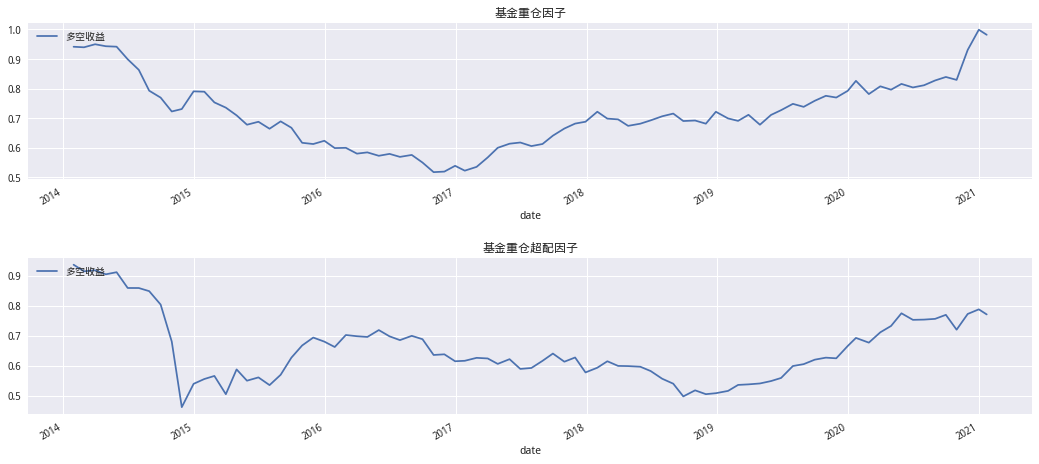

In [18]:
# 查看多空收益
fig, axes = plt.subplots(2, figsize=(18, 8))


ep.cum_returns(returns1['高'] - returns1['低']
               ).add(1).plot(ax=axes[0], title='基金重仓因子', label='多空收益')
axes[0].legend(loc='upper left')

ep.cum_returns(returns2['高'] - returns2['低']
               ).add(1).plot(ax=axes[1], title='基金重仓超配因子', label='多空收益')

axes[1].legend(loc='upper left')

plt.subplots_adjust(hspace=0.5)

基金重仓因子基本符合我的认知，高分组收益大于低分组收益。而基金重仓超配反而也有点奇怪，收益呈现U型分布。通过Mono Score(因子单调性得分)也能直观看到基金重仓因子单调性更高,基金重仓因子Mono Score得分为1.709,基金重仓超配因子仅为-0.69

In [19]:
# Mono得分
def get_mono_score(returns: pd.DataFrame, period: str = 'monthly') -> float:
    '''计算因子单调性得分'''
    annual_ret = ep.annual_return(returns, period)

    return (annual_ret[1] - annual_ret[10]) / (annual_ret[3] - annual_ret[8])

In [20]:
# 计算分组收益
mean_quant_ret1, std_quantile1 = perf.mean_return_by_quantile(
    factor_data1,
    by_group=False,
    demeaned=False,
    group_adjust=False,
)

mean_quant_ret2, std_quantil2e = perf.mean_return_by_quantile(
    factor_data2,
    by_group=False,
    demeaned=False,
    group_adjust=False)

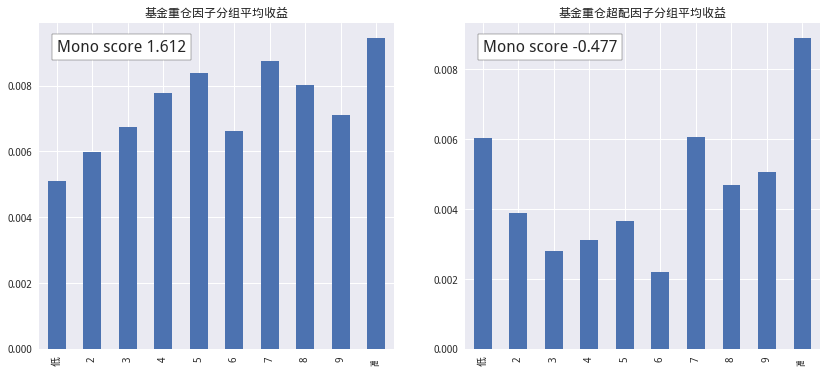

In [21]:
# 分组收益画图
mean_quant_ret1.index = ['低', 2, 3, 4, 5, 6, 7, 8, 9, '高']
mean_quant_ret2.index = ['低', 2, 3, 4, 5, 6, 7, 8, 9, '高']
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

mean_quant_ret1.plot.bar(title='基金重仓因子分组平均收益', ax=axes[0])
# 显示因子单调性得分
axes[0].text(.05, .95, "Mono score %.3f" % (get_mono_score(returns1.rename(columns={'高': 10, '低': 1}))),
             fontsize=16,
             bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5},
             transform=axes[0].transAxes,
             verticalalignment='top')
axes[0].legend([])

mean_quant_ret2.plot.bar(title='基金重仓超配因子分组平均收益', ax=axes[1])
axes[1].text(.05, .95, "Mono score %.3f" % (get_mono_score(returns2.rename(columns={'高': 10, '低': 1}))),
             fontsize=16,
             bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5},
             transform=axes[1].transAxes,
             verticalalignment='top')
axes[1].legend([])

从总的结果来看，基金重仓超配因子....滚动月度IC改进后大于0的概率反而变小了,IC均值也比原始因子要小从0.007减至0.002,波动性也随之减小,有0.085减小至0.12,这个滚动IC的时序图中也能看到。

In [22]:
# IC信息计算
def plot_information_table(ic_data:pd.DataFrame)->pd.DataFrame:
    ic_summary_table = pd.DataFrame()
    ic_summary_table["IC Mean"] = ic_data.mean()
    ic_summary_table["IC Std."] = ic_data.std()
    ic_summary_table["Risk-Adjusted IC"] = \
        ic_data.mean() / ic_data.std()
    t_stat, p_value = stats.ttest_1samp(ic_data, 0)
    ic_summary_table["t-stat(IC)"] = t_stat
    ic_summary_table["p-value(IC)"] = p_value
    ic_summary_table["IC Skew"] = stats.skew(ic_data)
    ic_summary_table["IC Kurtosis"] = stats.kurtosis(ic_data)

    return ic_summary_table.apply(lambda x: x.round(3)).T

,基金重仓因子,基金重仓超配因子
IC Mean,0.007,-0.000
IC Std.,0.085,0.137
Risk-Adjusted IC,0.084,-0.000
t-stat(IC),0.770,-0.003
p-value(IC),0.443,0.998
IC Skew,-0.092,-0.019
IC Kurtosis,-0.567,1.441


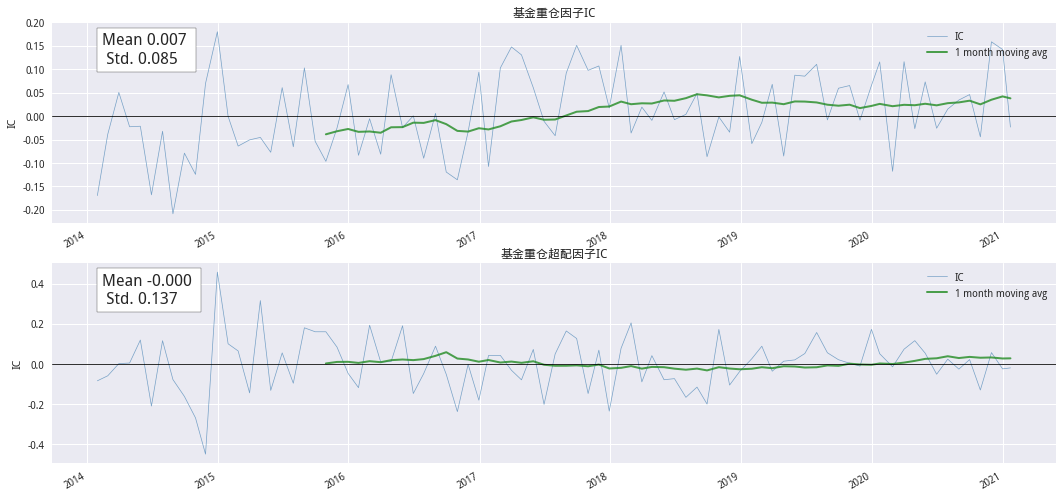

In [23]:
# 查看IC稳定性
ic1 = perf.factor_information_coefficient(factor_data1)
ic2 = perf.factor_information_coefficient(factor_data2)

ic_df = pd.concat((ic1,ic2),axis=1)
ic_df.columns = ['基金重仓因子','基金重仓超配因子']

al.utils.print_table(plot_information_table(ic_df))

# 画图
fig,axes = plt.subplots(2,figsize=(18,9))

plotting.plot_ic_ts(ic1,ax=[axes[0]])
axes[0].set_title('基金重仓因子IC')


plotting.plot_ic_ts(ic2,ax=[axes[1]])
axes[1].set_title('基金重仓超配因子IC');

In [24]:
# 计算分组IC情况
print('基金重仓因子')
group_ic1 = factor_data1.groupby('factor_quantile').apply(
    perf.factor_information_coefficient)
group_ic_table1 = group_ic1.groupby(level=0).apply(
    plot_information_table)[1].unstack()
group_ic_table1['IR'] = group_ic_table1['IC Mean'] / group_ic_table1['IC Std.']
group_ic_table1['IR'] = group_ic_table1['IR'].apply(lambda x: round(x, 3))
group_ic_table1.index = ['低', 2, 3, 4, 5, 6, 7, 8, 9, '高']
group_ic_table1

基金重仓因子


,IC Mean,IC Std.,Risk-Adjusted IC,t-stat(IC),p-value(IC),IC Skew,IC Kurtosis,IR
低,0.013,0.085,0.150,1.379,0.171,-0.191,1.638,0.153
2,-0.003,0.084,-0.034,-0.318,0.751,-0.417,-0.106,-0.036
3,-0.006,0.073,-0.081,-0.749,0.456,-0.121,-0.062,-0.082
4,0.007,0.070,0.097,0.893,0.374,0.013,0.339,0.100
5,-0.001,0.066,-0.012,-0.107,0.915,-0.258,0.850,-0.015
6,-0.002,0.068,-0.033,-0.301,0.764,-0.289,-0.279,-0.029
7,0.001,0.075,0.011,0.097,0.923,-0.465,1.020,0.013
8,0.002,0.075,0.028,0.263,0.794,-0.040,0.512,0.027
9,-0.007,0.072,-0.094,-0.868,0.388,-0.598,1.097,-0.097
高,0.022,0.134,0.163,1.505,0.136,0.024,-0.549,0.164


In [25]:
# 计算分组IC情况
print('基金重仓超配因子')
group_ic2 = factor_data2.groupby('factor_quantile').apply(
    perf.factor_information_coefficient)
group_ic_table2 = group_ic2.groupby(level=0).apply(
    plot_information_table)[1].unstack()
group_ic_table2['IR'] = group_ic_table2['IC Mean'] / group_ic_table2['IC Std.']
group_ic_table2['IR'] = group_ic_table2['IR'].apply(lambda x: round(x, 3))
group_ic_table2.index = ['低', 2, 3, 4, 5, 6, 7, 8, 9, '高']
group_ic_table2

基金重仓超配因子


,IC Mean,IC Std.,Risk-Adjusted IC,t-stat(IC),p-value(IC),IC Skew,IC Kurtosis,IR
低,-0.030,0.160,-0.185,-1.706,0.092,-0.022,-0.352,-0.188
2,-0.003,0.112,-0.023,-0.214,0.831,-0.044,0.466,-0.027
3,-0.015,0.107,-0.143,-1.322,0.190,0.275,1.136,-0.140
4,0.005,0.105,0.045,0.413,0.681,-0.285,0.191,0.048
5,0.012,0.101,0.124,1.141,0.257,0.076,0.535,0.119
6,0.018,0.119,0.148,1.367,0.175,-0.081,0.759,0.151
7,-0.002,0.114,-0.014,-0.126,0.900,-0.590,0.214,-0.018
8,0.001,0.101,0.010,0.090,0.928,0.883,1.960,0.010
9,-0.001,0.112,-0.006,-0.053,0.958,0.061,0.225,-0.009
高,0.010,0.130,0.078,0.718,0.475,0.303,0.382,0.077


### 1.3.1基金重仓超配因子大于0部分的表现情况

In [49]:
# periods 表示间隔为1 也就是季度换仓 group_df的时间是季度
factor_data2_1 = al.utils.get_clean_factor_and_forward_returns(dif_data[dif_data>0],
                                                            pricing,
                                                            quantiles=10,
                                                            periods=(1,))

Dropped 0.0% entries from factor data (0.0% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


In [50]:
# 分组收益
returns2_1 = get_factor_returns(factor_data2_1,{1:'低',10:'高'})

# 获取基准
benchmark = get_price('000300.XSHG', start, end, fields='close', panel=True)
benchmark = benchmark.reindex(pricing.index)

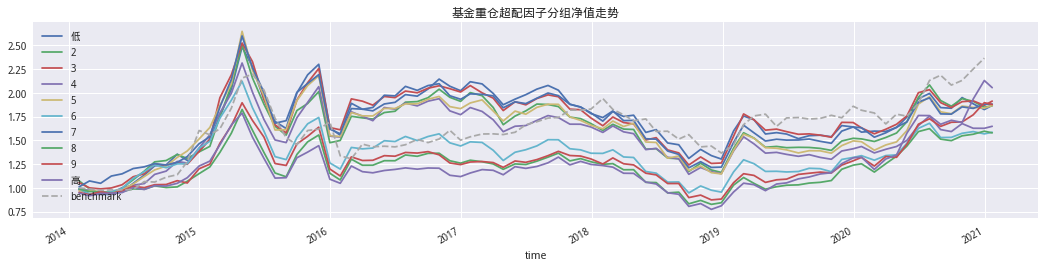

In [52]:
# 计算净值
nav_df2_1 = ep.cum_returns(returns2_1).add(1)

fig, axes = plt.subplots(figsize=(18, 4))
mpl.rcParams['font.family'] = 'serif'
plot_factor_returns(nav_df2_1,benchmark['close'],'基金重仓超配因子分组净值走势');

In [53]:
(Strategy_performance(returns2_1,'monthly').style.format('{:.2%}')
                                         .set_caption('基金重仓超配因子'))

factor_quantile,低,2,3,4,5,6,7,8,9,高
年化收益率,9.24%,9.20%,9.60%,7.32%,9.22%,6.73%,9.34%,6.67%,9.31%,10.71%
波动率,28.06%,28.06%,28.79%,25.91%,28.41%,26.71%,26.95%,26.43%,25.88%,26.50%
夏普,44.96%,44.80%,45.45%,39.66%,44.86%,37.32%,46.01%,37.10%,46.93%,51.24%
最大回撤,-47.55%,-53.62%,-50.87%,-50.61%,-56.69%,-55.37%,-53.39%,-54.73%,-53.93%,-56.70%
Calmar,19.42%,17.16%,18.87%,14.45%,16.27%,12.15%,17.50%,12.18%,17.26%,18.89%


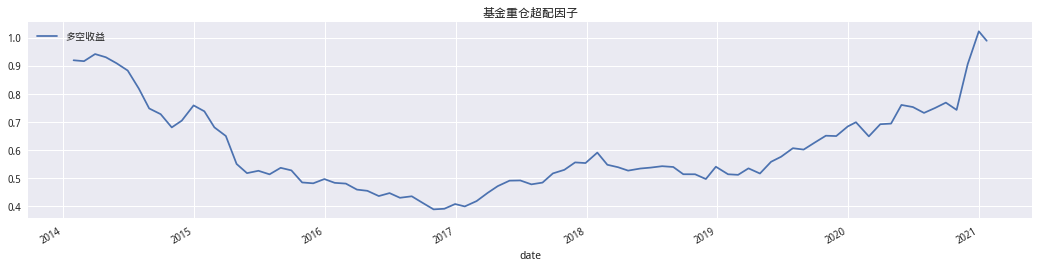

In [57]:
ep.cum_returns(returns2_1['高'] - returns1['低']
               ).add(1).plot(title='基金重仓超配因子', label='多空收益',figsize=(18,4))
plt.legend()

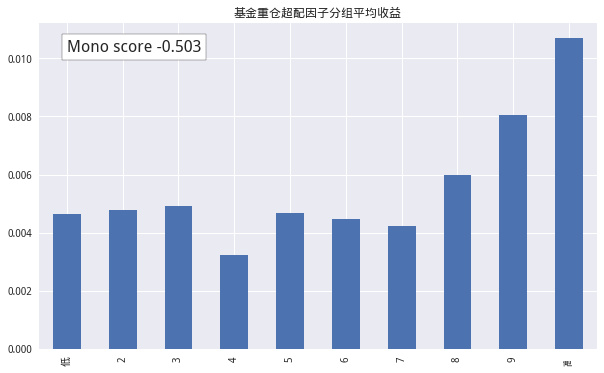

In [59]:
# 计算分组收益
mean_quant_ret2_1, _ = perf.mean_return_by_quantile(
    factor_data2_1,
    by_group=False,
    demeaned=False,
    group_adjust=False,
)

mean_quant_ret2_1.index = ['低', 2, 3, 4, 5, 6, 7, 8, 9, '高']
fig, axes = plt.subplots(figsize=(10, 6))

mean_quant_ret2_1.plot.bar(title='基金重仓超配因子分组平均收益', ax=axes)
# 显示因子单调性得分
axes.text(.05, .95, "Mono score %.3f" % (get_mono_score(returns2_1.rename(columns={'高': 10, '低': 1}))),
             fontsize=16,
             bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5},
             transform=axes.transAxes,
             verticalalignment='top')
axes.legend([])

## 1.4 不同样本空间中基金重仓超配因子的表现

### 1.4.1 沪深300

In [26]:
# 数据获取
dif_hs300 = get_fundmkt_diff(handle_data,'000300.XSHG')

# periods 表示间隔为1 也就是季度换仓 group_df的时间是季度
hs300_df = al.utils.get_clean_factor_and_forward_returns(dif_hs300,
                                                            pricing,
                                                            quantiles=10,
                                                            periods=(1,))

Dropped 0.0% entries from factor data (0.0% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


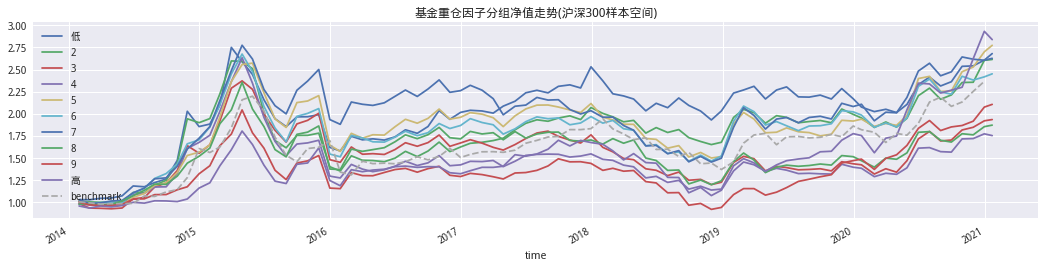

In [27]:
# 分组收益
hs300_ret = get_factor_returns(hs300_df,{1:'低',10:'高'})

# 获取基准
benchmark = get_price('000300.XSHG', start, end, fields='close', panel=True)
benchmark = benchmark.reindex(pricing.index)

# 计算净值
hs300_nav = ep.cum_returns(hs300_ret).add(1)

fig, ax = plt.subplots(figsize=(18, 4))
plot_factor_returns(hs300_nav,benchmark['close'],'基金重仓因子分组净值走势(沪深300样本空间)',ax)

In [44]:
(Strategy_performance(hs300_ret,'monthly').style.format('{:.2%}')
                                         .set_caption('基金重仓超配因子(HS300中)'))

factor_quantile,低,2,3,4,5,6,7,8,9,高
年化收益率,14.94%,14.53%,9.75%,8.23%,15.50%,13.49%,14.61%,9.24%,11.08%,15.87%
波动率,26.28%,26.01%,25.30%,25.46%,25.93%,26.08%,24.74%,24.84%,24.02%,26.33%
夏普,64.68%,64.36%,48.82%,43.13%,67.98%,61.01%,66.97%,47.62%,55.46%,68.73%
最大回撤,-42.65%,-48.05%,-49.57%,-56.96%,-41.80%,-45.42%,-47.71%,-49.26%,-55.19%,-40.57%
Calmar,35.02%,30.24%,19.67%,14.46%,37.08%,29.71%,30.62%,18.76%,20.08%,39.13%


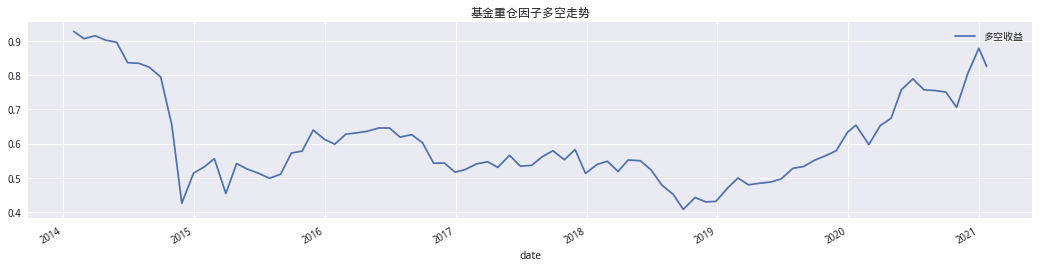

In [28]:
# 因子多空走势
ep.cum_returns(hs300_ret['高'] - hs300_ret['低']
               ).add(1).plot(title='基金重仓因子多空走势', label='多空收益',figsize=(18,4))
plt.legend();

,1
IC Mean,-0.001
IC Std.,0.191
Risk-Adjusted IC,-0.008
t-stat(IC),-0.069
p-value(IC),0.945
IC Skew,-0.044
IC Kurtosis,0.221


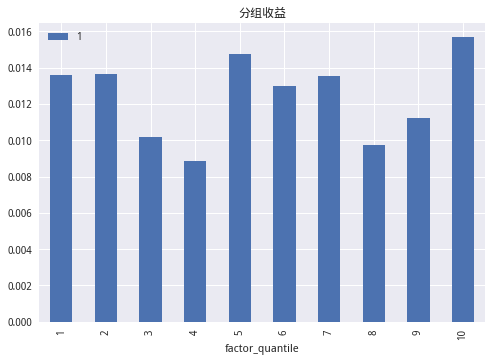

In [29]:
# 查看IC稳定性
hs300_ic = perf.factor_information_coefficient(hs300_df)

al.utils.print_table(plot_information_table(hs300_ic))

mean_quant_ret1, std_quantile1 = perf.mean_return_by_quantile(
    hs300_df,
    by_group=False,
    demeaned=False,
    group_adjust=False,
)

mean_quant_ret1.plot.bar(title='分组收益');

**重仓超配因子大于0的部分**

可以看到超配因子中大于0的部分多空稳定性效果更好

In [61]:
# periods 表示间隔为1 也就是季度换仓 group_df的时间是季度
hs300_df1 = al.utils.get_clean_factor_and_forward_returns(dif_hs300[dif_hs300 > 0],
                                                            pricing,
                                                            quantiles=10,
                                                            periods=(1,))

Dropped 0.0% entries from factor data (0.0% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


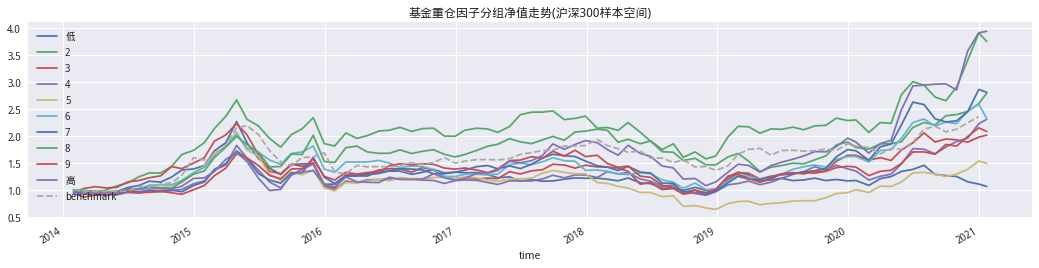

In [62]:
# 分组收益
hs300_ret1 = get_factor_returns(hs300_df1,{1:'低',10:'高'})

# 获取基准
benchmark = get_price('000300.XSHG', start, end, fields='close', panel=True)
benchmark = benchmark.reindex(pricing.index)

# 计算净值
hs300_nav1 = ep.cum_returns(hs300_ret1).add(1)

fig, ax = plt.subplots(figsize=(18, 4))
plot_factor_returns(hs300_nav1,benchmark['close'],'基金重仓因子分组净值走势(沪深300样本空间)',ax)

In [63]:
(Strategy_performance(hs300_ret1,'monthly').style.format('{:.2%}')
                                         .set_caption('基金重仓超配因子(HS300中)'))

factor_quantile,低,2,3,4,5,6,7,8,9,高
年化收益率,0.96%,15.64%,10.45%,12.57%,5.89%,12.70%,15.73%,20.55%,10.97%,21.38%
波动率,25.83%,24.28%,28.64%,28.58%,27.21%,24.88%,29.43%,28.44%,26.64%,31.97%
夏普,16.02%,71.73%,48.84%,55.29%,34.44%,60.08%,63.83%,79.52%,51.66%,76.03%
最大回撤,-56.14%,-49.75%,-58.50%,-50.48%,-69.02%,-50.30%,-46.91%,-28.30%,-46.70%,-43.52%
Calmar,1.71%,31.43%,17.86%,24.91%,8.53%,25.25%,33.54%,72.62%,23.48%,49.13%


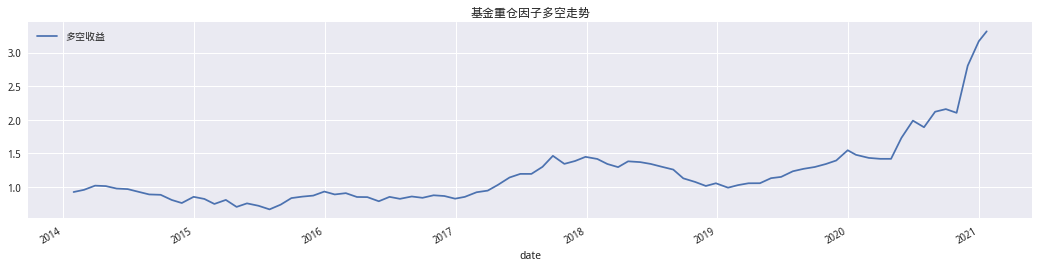

In [64]:
# 因子多空走势
ep.cum_returns(hs300_ret1['高'] - hs300_ret1['低']
               ).add(1).plot(title='基金重仓因子多空走势', label='多空收益',figsize=(18,4))
plt.legend();

,1
IC Mean,0.028
IC Std.,0.177
Risk-Adjusted IC,0.160
t-stat(IC),1.480
p-value(IC),0.143
IC Skew,0.197
IC Kurtosis,-0.108


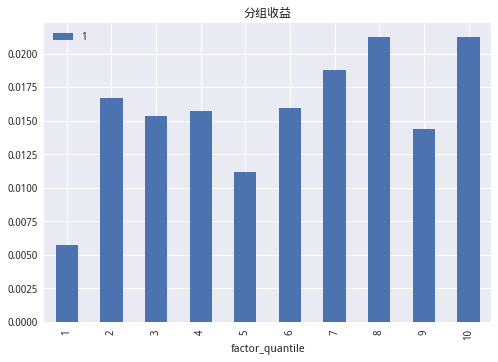

In [65]:
# 查看IC稳定性
hs300_ic1 = perf.factor_information_coefficient(hs300_df1)

al.utils.print_table(plot_information_table(hs300_ic1))

mean_quant_ret1, std_quantile1 = perf.mean_return_by_quantile(
    hs300_df1,
    by_group=False,
    demeaned=False,
    group_adjust=False,
)

mean_quant_ret1.plot.bar(title='分组收益');

### 1.4.2 中证500

可以看到在中证500中因子的多空稳定性更好

In [30]:
# 数据获取
dif_zz500 = get_fundmkt_diff(handle_data,'000905.XSHG')

# periods 表示间隔为1 也就是季度换仓 group_df的时间是季度
zz500_df = al.utils.get_clean_factor_and_forward_returns(dif_zz500,
                                                            pricing,
                                                            quantiles=10,
                                                            periods=(1,))

Dropped 0.0% entries from factor data (0.0% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


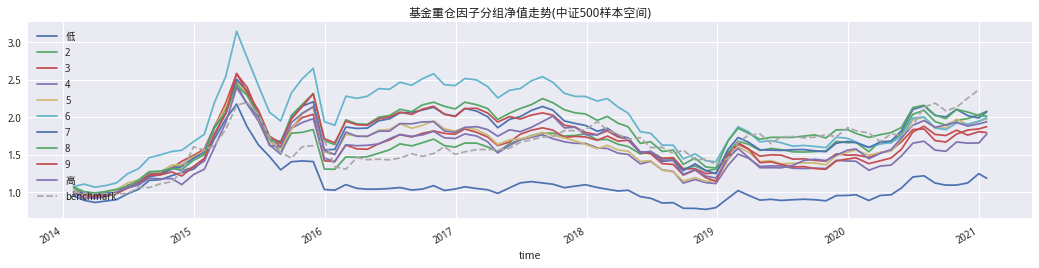

In [31]:
# 分组收益
zz500_ret = get_factor_returns(zz500_df,{1:'低',10:'高'})

# 获取基准
benchmark = get_price('000300.XSHG', start, end, fields='close', panel=True)
benchmark = benchmark.reindex(pricing.index)

# 计算净值
zz500_nav = ep.cum_returns(zz500_ret).add(1)

fig, ax = plt.subplots(figsize=(18, 4))
plot_factor_returns(zz500_nav,benchmark['close'],'基金重仓因子分组净值走势(中证500样本空间)',ax);

In [46]:
(Strategy_performance(zz500_ret,'monthly').style.format('{:.2%}')
                                         .set_caption('基金重仓超配因子(中证500中)'))

factor_quantile,低,2,3,4,5,6,7,8,9,高
年化收益率,2.43%,10.87%,9.26%,8.42%,10.08%,10.22%,10.81%,10.38%,8.60%,9.79%
波动率,24.51%,24.96%,26.03%,27.60%,26.99%,28.36%,27.76%,27.87%,29.53%,28.92%
夏普,21.57%,53.60%,46.82%,42.36%,48.59%,47.79%,50.30%,48.63%,41.75%,46.07%
最大回撤,-64.50%,-47.76%,-51.54%,-54.13%,-53.95%,-55.30%,-50.19%,-45.27%,-55.63%,-50.29%
Calmar,3.77%,22.76%,17.97%,15.55%,18.68%,18.47%,21.55%,22.94%,15.45%,19.46%


在创业板中多空稳定性较好

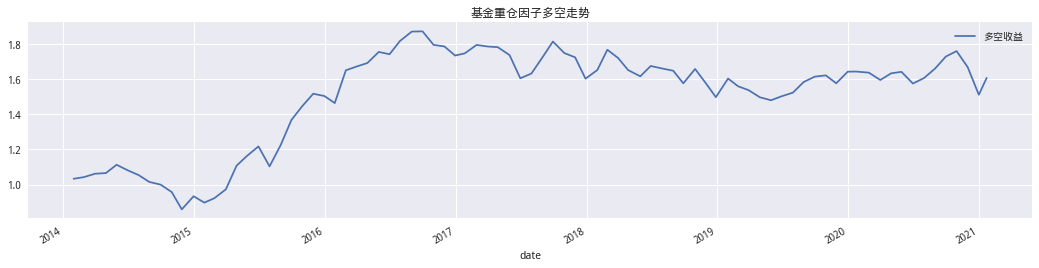

In [70]:
# 因子多空走势
ep.cum_returns(zz500_ret['高'] - zz500_ret['低']
               ).add(1).plot(title='基金重仓因子多空走势', label='多空收益',figsize=(18,4))
plt.legend();

,1
IC Mean,0.008
IC Std.,0.120
Risk-Adjusted IC,0.065
t-stat(IC),0.601
p-value(IC),0.550
IC Skew,0.165
IC Kurtosis,-0.565


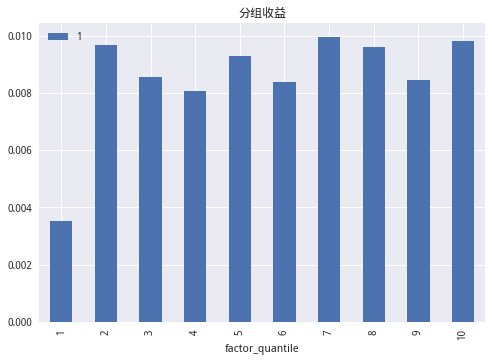

In [33]:
# 查看IC稳定性
zz500_ic = perf.factor_information_coefficient(zz500_df)

al.utils.print_table(plot_information_table(zz500_ic))

mean_quant_ret1, std_quantile1 = perf.mean_return_by_quantile(
    zz500_df,
    by_group=False,
    demeaned=False,
    group_adjust=False,
)

mean_quant_ret1.plot.bar(title='分组收益');

**重仓超配因子大于0的部分**

可以看到超配因子中大于0的部分多空稳定性效果更好

In [67]:
# periods 表示间隔为1 也就是季度换仓 group_df的时间是季度
zz500_df1 = al.utils.get_clean_factor_and_forward_returns(dif_zz500[dif_zz500 > 0],
                                                            pricing,
                                                            quantiles=10,
                                                            periods=(1,))

Dropped 0.0% entries from factor data (0.0% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


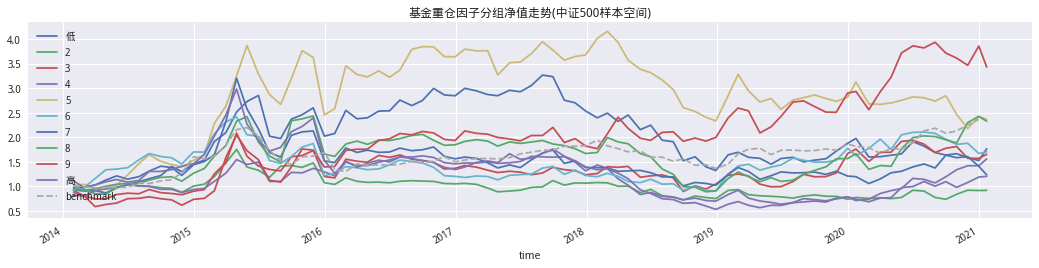

In [68]:
# 分组收益
zz500_ret1 = get_factor_returns(zz500_df1,{1:'低',10:'高'})

# 计算净值
zz500_nav1 = ep.cum_returns(zz500_ret1).add(1)

fig, ax = plt.subplots(figsize=(18, 4))
plot_factor_returns(zz500_nav1,benchmark['close'],'基金重仓因子分组净值走势(中证500样本空间)',ax);

In [69]:
(Strategy_performance(zz500_ret1,'monthly').style.format('{:.2%}')
                                         .set_caption('基金重仓超配因子(中证500中)'))

factor_quantile,低,2,3,4,5,6,7,8,9,高
年化收益率,8.37%,-1.16%,7.36%,6.49%,12.94%,7.81%,3.04%,12.67%,19.01%,2.68%
波动率,33.77%,30.61%,40.26%,31.74%,37.78%,34.78%,38.69%,40.46%,47.59%,37.56%
夏普,40.42%,10.81%,36.44%,35.06%,49.99%,38.72%,25.74%,48.10%,57.64%,25.81%
最大回撤,-59.47%,-58.74%,-57.02%,-60.73%,-47.59%,-62.26%,-68.45%,-63.33%,-46.88%,-82.14%
Calmar,14.08%,-1.97%,12.90%,10.68%,27.18%,12.54%,4.44%,20.01%,40.55%,3.26%


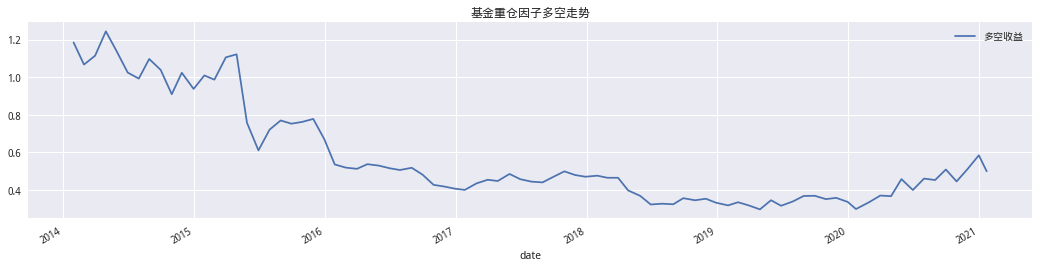

In [71]:
# 因子多空走势
ep.cum_returns(zz500_ret1['高'] - zz500_ret1['低']
               ).add(1).plot(title='基金重仓因子多空走势', label='多空收益',figsize=(18,4))
plt.legend();

### 1.4.3 创业板

仔细一点的话可以发现2019年以后第1组反而比超配的第10组要好。基金重仓股在创业板上的配置应该较少。

In [34]:
# 数据获取
dif_cyb = get_fundmkt_diff(handle_data,'399006.XSHE')

# periods 表示间隔为1 也就是季度换仓 group_df的时间是季度
cyb_df = al.utils.get_clean_factor_and_forward_returns(dif_cyb,
                                                        pricing,
                                                        quantiles=10,
                                                        periods=(1,))

Dropped 0.0% entries from factor data (0.0% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


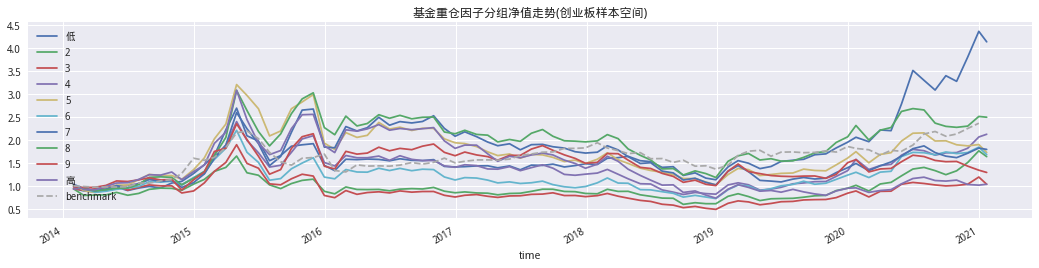

In [35]:
# 分组收益
cyb_ret = get_factor_returns(cyb_df,{1:'低',10:'高'})

# 获取基准
benchmark = get_price('000300.XSHG', start, end, fields='close', panel=True)
benchmark = benchmark.reindex(pricing.index)

# 计算净值
cyb_nav = ep.cum_returns(cyb_ret).add(1)

fig, ax = plt.subplots(figsize=(18, 4))
plot_factor_returns(cyb_nav,benchmark['close'],'基金重仓因子分组净值走势(创业板样本空间)',ax)

In [60]:
(Strategy_performance(cyb_ret,'monthly').style.format('{:.2%}')
                                         .set_caption('基金重仓超配因子(创业板中)'))

factor_quantile,低,2,3,4,5,6,7,8,9,高
年化收益率,22.20%,7.23%,0.53%,11.24%,8.04%,7.63%,8.62%,13.79%,3.72%,0.54%
波动率,34.82%,31.34%,35.10%,33.50%,36.25%,33.35%,39.42%,38.55%,40.21%,39.63%
夏普,74.36%,37.43%,18.88%,47.85%,38.81%,38.29%,39.55%,51.08%,28.01%,19.65%
最大回撤,-57.84%,-63.64%,-74.10%,-66.04%,-68.08%,-67.16%,-61.71%,-61.53%,-57.15%,-76.15%
Calmar,38.38%,11.36%,0.71%,17.02%,11.82%,11.36%,13.97%,22.41%,6.51%,0.71%


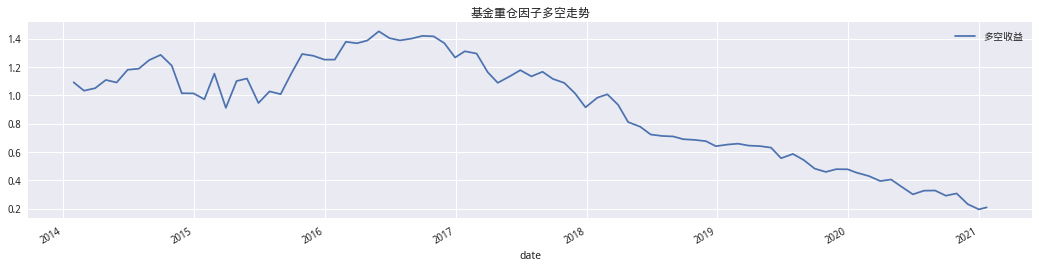

In [36]:
# 因子多空走势
ep.cum_returns(cyb_ret['高'] - cyb_ret['低']
               ).add(1).plot(title='基金重仓因子多空走势', label='多空收益',figsize=(18,4))
plt.legend();

,1
IC Mean,-0.020
IC Std.,0.176
Risk-Adjusted IC,-0.113
t-stat(IC),-1.042
p-value(IC),0.300
IC Skew,-0.064
IC Kurtosis,-0.230


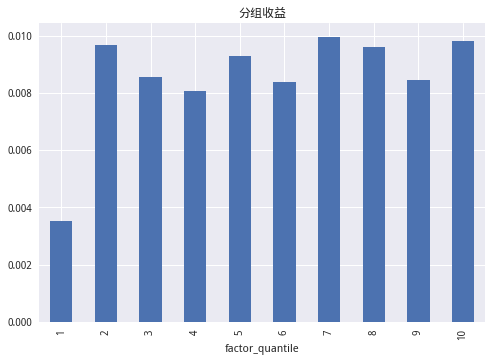

In [37]:
# 查看IC稳定性
cyb_ic = perf.factor_information_coefficient(cyb_df)

al.utils.print_table(plot_information_table(cyb_ic))

mean_quant_ret1, std_quantile1 = perf.mean_return_by_quantile(
    zz500_df,
    by_group=False,
    demeaned=False,
    group_adjust=False,
)

mean_quant_ret1.plot.bar(title='分组收益')
plt.legend([]);

## 2. 基于基金池优化因子

### 2.1 夏普优化基金池

通过利用《来自优秀基金经理的超额收益》一篇的结论使用过去180日的夏普作为筛选基金的条件。选取夏普头部10%组的基金构建重仓股因子。

In [59]:
# 获取基金持仓数据 60m
handle_data1 = query_fundhandle_data(start,end,_filter_sharpe_fund)

In [62]:
# 储存
# handle_data1.to_csv('handle_data1.csv')

In [5]:
# 读取
handle_data1 = pd.read_csv('handle_data.csv',index_col=[0,1],parse_dates=[0],header=None)
handle_data1.index.names = ['date','code']
handle_data1.columns = ['factor']
handle_data1 = handle_data1['factor']
handle_data1.head()

date        code       
2014-01-30  000001.XSHE    0.003291
            000002.XSHE    0.010730
            000006.XSHE    0.000476
            000024.XSHE    0.003008
            000063.XSHE    0.014380
Name: factor, dtype: float64

In [10]:
last_period = '2021-02-22'
pricing1 = get_stock_price(handle_data1,last_period)

In [11]:
# 数据获取
dif_data1 = get_fundmkt_diff(handle_data1,'000300.XSHG')

In [12]:
# periods 表示间隔为1 也就是季度换仓 group_df的时间是季度
factor_data3 = al.utils.get_clean_factor_and_forward_returns(handle_data1,
                                                            pricing1,
                                                            quantiles=10,
                                                            periods=(1,))

# periods 表示间隔为1 也就是季度换仓 group_df的时间是季度
factor_data4 = al.utils.get_clean_factor_and_forward_returns(dif_data1,
                                                            pricing1,
                                                            quantiles=10,
                                                            periods=(1,))

Dropped 0.1% entries from factor data (0.1% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.
Dropped 0.0% entries from factor data (0.0% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


In [1]:
# 分组收益
returns3 =get_factor_returns(factor_data3,{1:'低',10:'高'})

returns4 = get_factor_returns(factor_data4,{1:'低',10:'高'})

# 获取基准
benchmark = get_price('000300.XSHG', start, end, fields='close', panel=True)
benchmark = benchmark.reindex(pricing1.index)

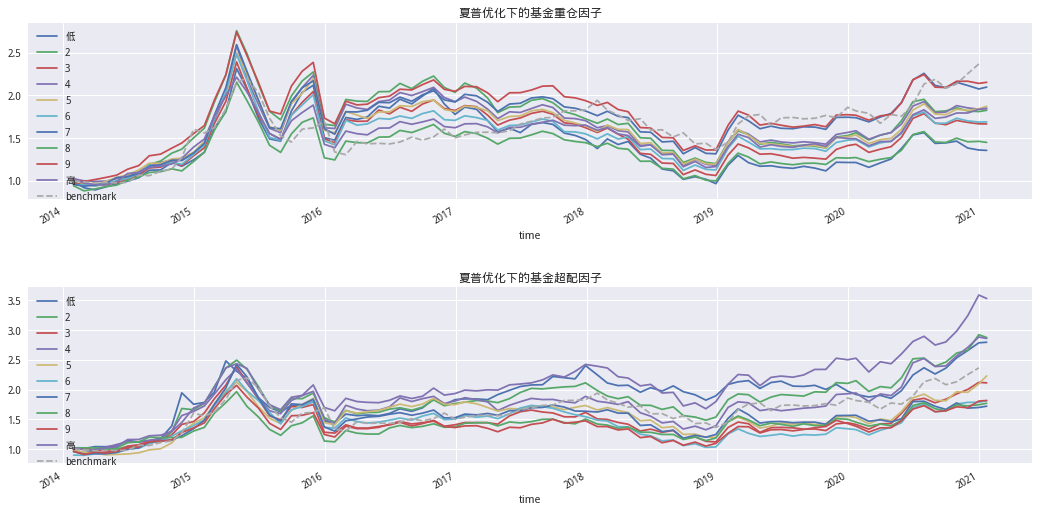

In [80]:
# 计算净值
nav_df3 = ep.cum_returns(returns3).add(1)
nav_df4 = ep.cum_returns(returns4).add(1)


mpl.rcParams['font.family'] = 'serif'
fig, axes = plt.subplots(2, figsize=(18, 9))

plot_factor_returns(nav_df3,benchmark['close'],'夏普优化下的基金重仓因子',axes[0])
plot_factor_returns(nav_df4,benchmark['close'],'夏普优化下的基金超配因子',axes[1])
plt.subplots_adjust(hspace=0.5)

,夏普优化下的基金重仓因子,夏普优化下的基金超配因子
IC Mean,0.017,-0.003
IC Std.,0.072,0.122
Risk-Adjusted IC,0.232,-0.026
t-stat(IC),2.142,-0.237
p-value(IC),0.035,0.813
IC Skew,0.001,-0.137
IC Kurtosis,-0.957,1.326


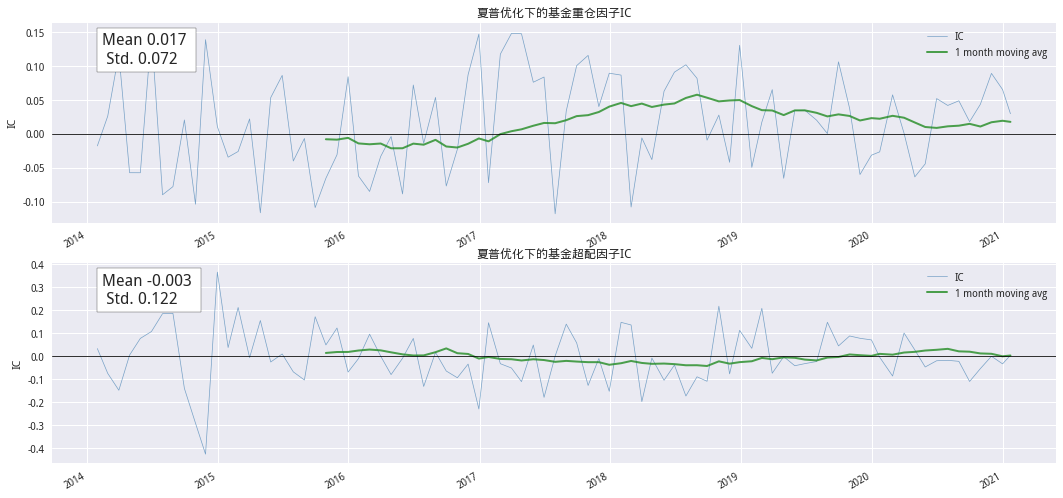

In [82]:
# 查看IC稳定性
ic1 = perf.factor_information_coefficient(factor_data3)
ic2 = perf.factor_information_coefficient(factor_data4)

ic_df = pd.concat((ic1,ic2),axis=1)
ic_df.columns = ['夏普优化下的基金重仓因子','夏普优化下的基金超配因子']

al.utils.print_table(plot_information_table(ic_df))

# 画图
fig,axes = plt.subplots(2,figsize=(18,9))

plotting.plot_ic_ts(ic1,ax=[axes[0]])
axes[0].set_title('夏普优化下的基金重仓因子IC')


plotting.plot_ic_ts(ic2,ax=[axes[1]])
axes[1].set_title('夏普优化下的基金超配因子IC');

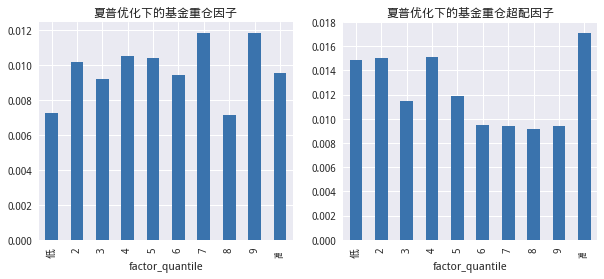

In [87]:
fig,axes = plt.subplots(1,2,figsize=(10,4))
returns3.mean().plot.bar(ax=axes[0],title='夏普优化下的基金重仓因子',color='#3A73AD')
returns4.mean().plot.bar(ax=axes[1],title='夏普优化下的基金重仓超配因子',color='#3A73AD')

**基金重仓超配因子大于0的部分**

使用夏普作为选择基金的股票池，收益明显比使用累计收益率更好。

In [80]:
# periods 表示间隔为1 也就是季度换仓 group_df的时间是季度
factor_data4_1 = al.utils.get_clean_factor_and_forward_returns(dif_data1[dif_data1 > 0],
                                                            pricing1,
                                                            quantiles=10,
                                                            periods=(1,))

Dropped 0.0% entries from factor data (0.0% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


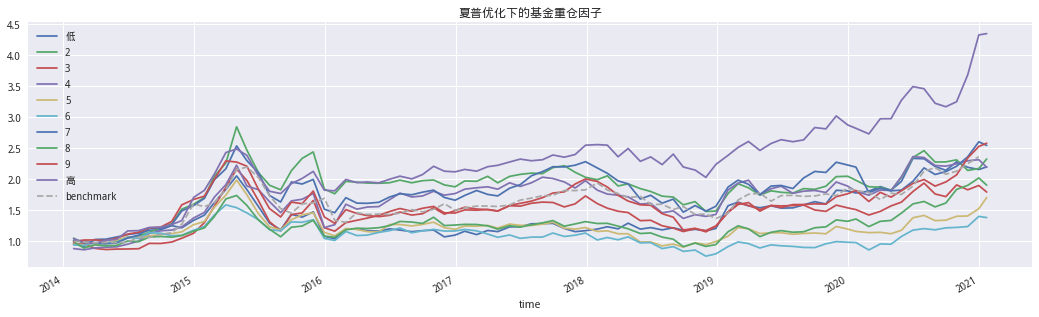

In [85]:
returns4_1 = get_factor_returns(factor_data4_1,{1:'低',10:'高'})
nav_df4_1 = ep.cum_returns(returns4_1).add(1)

plt.figure(figsize=(18,5))
plot_factor_returns(nav_df4_1,benchmark['close'],'夏普优化下的基金重仓因子');

In [88]:
(Strategy_performance(returns4_1,'monthly').style.format('{:.2%}')
                                         .set_caption('夏普优化下的基金重仓因子'))

factor_quantile,低,2,3,4,5,6,7,8,9,高
年化收益率,11.78%,12.67%,8.61%,11.73%,7.84%,4.68%,14.11%,9.53%,14.34%,23.08%
波动率,27.29%,26.78%,28.23%,28.65%,24.11%,23.28%,27.63%,24.88%,26.61%,23.34%
夏普,53.82%,57.30%,42.89%,52.67%,42.83%,30.69%,61.33%,48.38%,63.37%,100.25%
最大回撤,-49.38%,-48.00%,-46.60%,-45.20%,-54.44%,-52.13%,-42.46%,-47.48%,-49.84%,-28.88%
Calmar,23.86%,26.40%,18.47%,25.95%,14.40%,8.98%,33.24%,20.08%,28.77%,79.91%


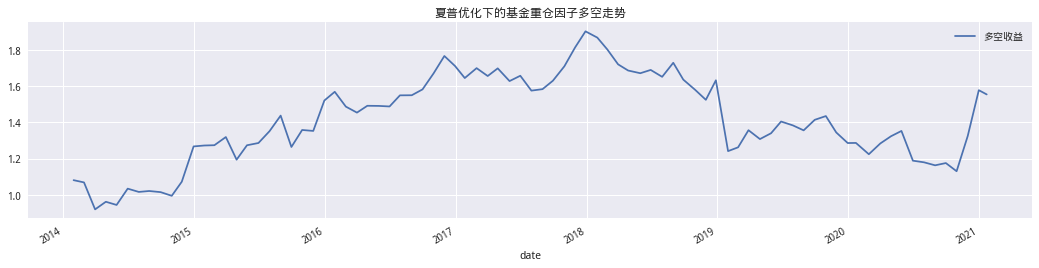

In [89]:
# 因子多空走势
ep.cum_returns(returns4_1['高'] - returns4_1['低']
               ).add(1).plot(title='夏普优化下的基金重仓因子多空走势', label='多空收益',figsize=(18,4))
plt.legend();

## 2.2 累计收益率优化基金池

In [91]:
# 获取基金持仓数据 54m27s
handle_data2 = query_fundhandle_data(start,end,_filter_annual_fund)

In [92]:
# 储存
# handle_data2.to_csv('handle_data2.csv')

In [111]:
handle_data2 = pd.read_csv('handle_data2.csv',index_col=[0,1],parse_dates=[0],header=None)
handle_data2.index.names = ['date','code']
handle_data2.columns = ['factor']
handle_data2 = handle_data2['factor']

In [116]:
last_period = '2021-02-22'
pricing2 = get_stock_price(handle_data2,last_period)

In [117]:
# 数据获取
dif_data6 = get_fundmkt_diff(handle_data2,'000300.XSHG')

In [118]:
# periods 表示间隔为1 也就是季度换仓 group_df的时间是季度
factor_data5 = al.utils.get_clean_factor_and_forward_returns(handle_data2,
                                                            pricing2,
                                                            quantiles=10,
                                                            periods=(1,))

# periods 表示间隔为1 也就是季度换仓 group_df的时间是季度
factor_data6 = al.utils.get_clean_factor_and_forward_returns(dif_data6,
                                                            pricing2,
                                                            quantiles=10,
                                                            periods=(1,))

Dropped 0.0% entries from factor data (0.0% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.
Dropped 0.0% entries from factor data (0.0% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


In [121]:
# 分组收益
returns5 =get_factor_returns(factor_data5,{1:'低',10:'高'})

returns6 = get_factor_returns(factor_data6,{1:'低',10:'高'})

# 获取基准
benchmark = get_price('000300.XSHG', start, end, fields='close', panel=True)
benchmark = benchmark.reindex(pricing1.index)

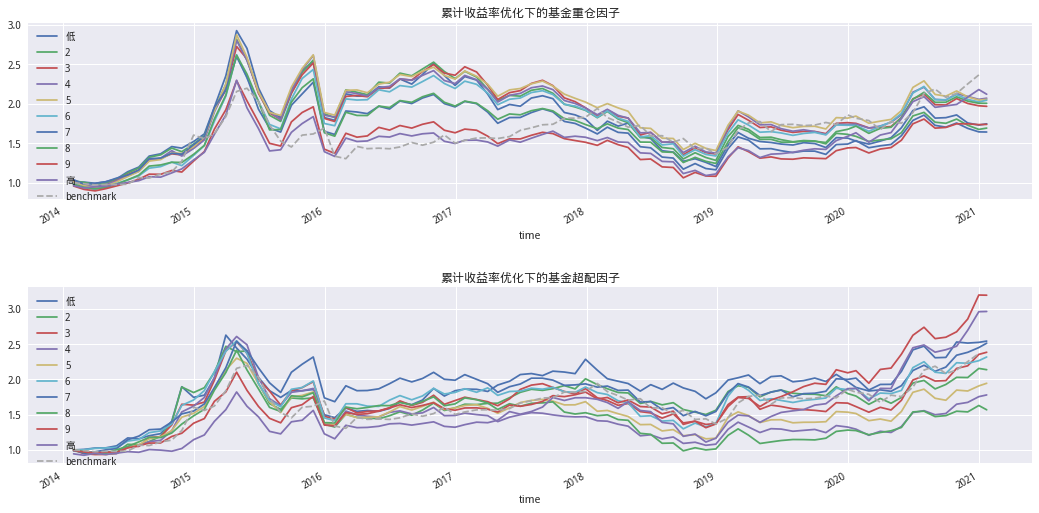

In [122]:
# 计算净值
nav_df5 = ep.cum_returns(returns5).add(1)
nav_df6 = ep.cum_returns(returns6).add(1)


mpl.rcParams['font.family'] = 'serif'
fig, axes = plt.subplots(2, figsize=(18, 9))

plot_factor_returns(nav_df5,benchmark['close'],'累计收益率优化下的基金重仓因子',axes[0])
plot_factor_returns(nav_df6,benchmark['close'],'累计收益率优化下的基金超配因子',axes[1])
plt.subplots_adjust(hspace=0.5)

,累计收益率优化下的基金重仓因子,累计收益率优化下的基金超配因子
IC Mean,0.008,0.007
IC Std.,0.087,0.186
Risk-Adjusted IC,0.091,0.037
t-stat(IC),0.841,0.344
p-value(IC),0.403,0.731
IC Skew,-0.196,-0.060
IC Kurtosis,-0.471,0.317


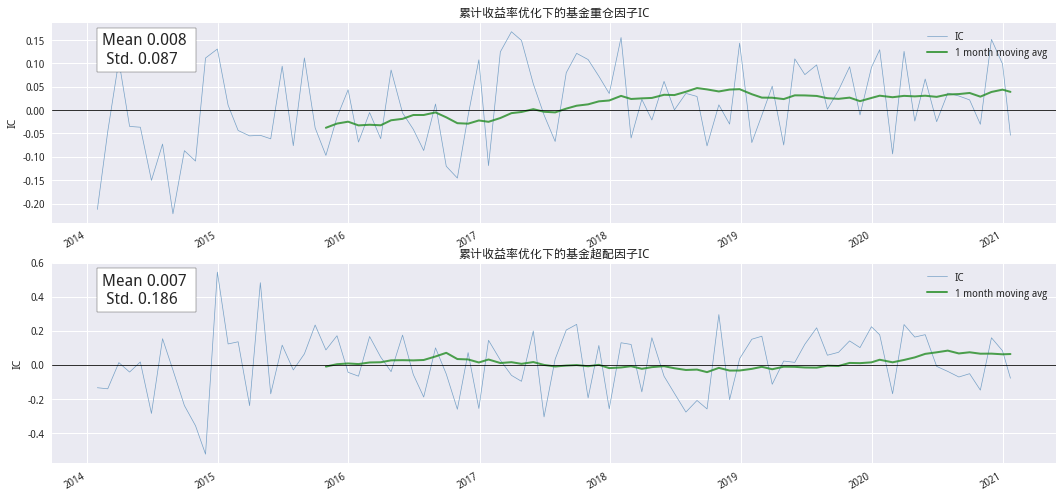

In [123]:
# 查看IC稳定性
ic3 = perf.factor_information_coefficient(factor_data5)
ic4 = perf.factor_information_coefficient(factor_data6)

ic_df = pd.concat((ic3,ic4),axis=1)
ic_df.columns = ['累计收益率优化下的基金重仓因子','累计收益率优化下的基金超配因子']

al.utils.print_table(plot_information_table(ic_df))

# 画图
fig,axes = plt.subplots(2,figsize=(18,9))

plotting.plot_ic_ts(ic3,ax=[axes[0]])
axes[0].set_title('累计收益率优化下的基金重仓因子IC')


plotting.plot_ic_ts(ic4,ax=[axes[1]])
axes[1].set_title('累计收益率优化下的基金超配因子IC');

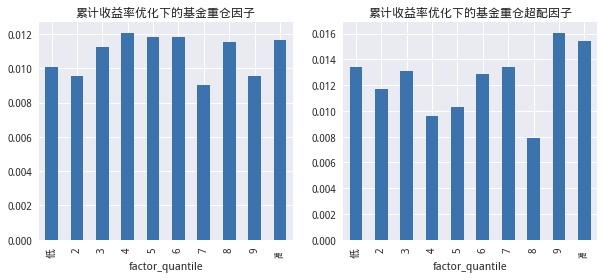

In [124]:
fig,axes = plt.subplots(1,2,figsize=(10,4))
returns5.mean().plot.bar(ax=axes[0],title='累计收益率优化下的基金重仓因子',color='#3A73AD')
returns6.mean().plot.bar(ax=axes[1],title='累计收益率优化下的基金重仓超配因子',color='#3A73AD')

**基金重仓超配因子大于0的部分**

In [119]:
# periods 表示间隔为1 也就是季度换仓 group_df的时间是季度
factor_data6_1 = al.utils.get_clean_factor_and_forward_returns(dif_data6[dif_data6 > 0],
                                                            pricing2,
                                                            quantiles=10,
                                                            periods=(1,))

Dropped 0.0% entries from factor data (0.0% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


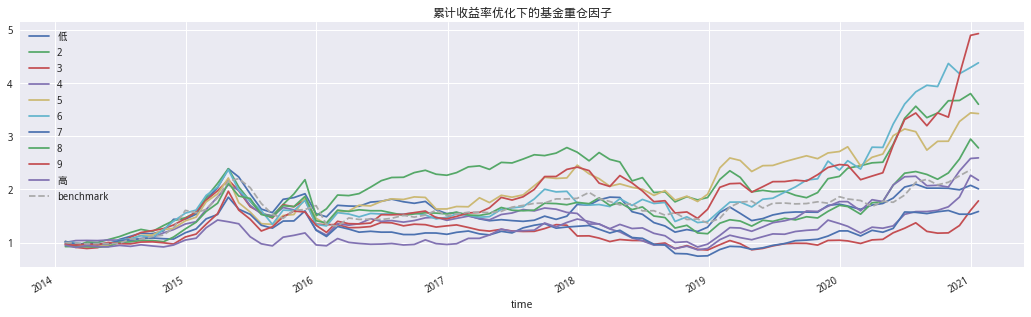

In [125]:
returns6_1 = get_factor_returns(factor_data6_1,{1:'低',10:'高'})
nav_df6_1 = ep.cum_returns(returns6_1).add(1)

plt.figure(figsize=(18,5))
plot_factor_returns(nav_df6_1,benchmark['close'],'累计收益率优化下的基金重仓因子');

In [126]:
(Strategy_performance(returns6_1,'monthly').style.format('{:.2%}')
                                         .set_caption('累计收益率优化下的基金重仓因子'))

factor_quantile,低,2,3,4,5,6,7,8,9,高
年化收益率,10.34%,19.81%,8.50%,11.56%,18.96%,23.17%,6.70%,15.51%,25.24%,14.38%
波动率,25.78%,28.22%,25.92%,26.03%,28.35%,29.48%,25.88%,27.49%,31.47%,26.15%
夏普,50.37%,78.49%,44.06%,54.34%,75.17%,85.56%,37.26%,65.79%,86.69%,63.92%
最大回撤,-49.89%,-37.10%,-60.53%,-58.61%,-39.38%,-44.60%,-59.81%,-44.91%,-39.86%,-36.47%
Calmar,20.73%,53.39%,14.04%,19.73%,48.15%,51.94%,11.20%,34.54%,63.32%,39.42%


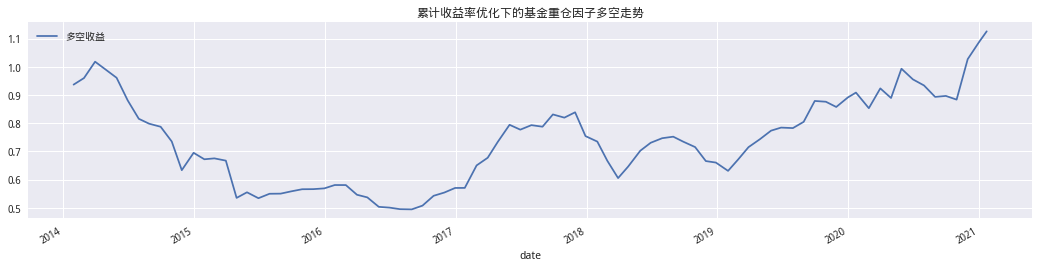

In [128]:
# 因子多空走势
ep.cum_returns(returns6_1['高'] - returns6_1['低']
               ).add(1).plot(title='累计收益率优化下的基金重仓因子多空走势', label='多空收益',figsize=(18,4))
plt.legend();